In [3]:
from __future__ import division, print_function
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.io.ascii as at
import astropy.io.fits as fits
import astropy.table as table
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.ticker
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.font_manager import FontProperties
import palettable

import K2fov.projection as proj
import K2fov.fov as fov
from K2fov.K2onSilicon import angSepVincenty,getRaDecRollFromFieldnum

import PHEW
from hypra.utils import cat_match, cat_io, k2utils
# from hypra.plot import color_mag
import convertmass

In [4]:
# pdat,pobs,pobsnr,pobsr = cat_io.get_data("P")
hdat,hobs,hobsnr,hobsr = cat_io.get_data("H")
print(hdat.dtype)
hpos = SkyCoord(hdat["RA"],hdat["DEC"],unit=u.degree)

(numpy.record, [('RA', '>f8'), ('DEC', '>f8'), ('ASAS_ID', 'S13'), ('HIP_ID', 'S9'), ('KUNDERT_MATCH', '>f4'), ('KUNDERT_RA', '>f4'), ('KUNDERT_DEC', '>f4'), ('KUNDERT_PROT', '>f4'), ('KUNDERT_OBS', '>f4'), ('KUNDERT_SPT', 'S5'), ('ROESER_MATCH', '>i4'), ('ROESER_PMRA', '>f4'), ('ROESER_PMRA_ERR', '>f4'), ('ROESER_PMDEC', '>f4'), ('ROESER_PMDEC_ERR', '>f4'), ('ROESER_PARALLAX', '>f4'), ('ROESER_PARALLAX_ERR', '>f4'), ('ROESER_DISTANCE', '>f4'), ('ROESER_RV', '>f4'), ('ROESER_VPAR', '>f4'), ('ROESER_VPAR_ERR', '>f4'), ('ROESER_VPER', '>f4'), ('ROESER_VPER_ERR', '>f4'), ('ROESER_MASS', '>f4'), ('TWOMASSNAME', 'S16'), ('TWOMASS_RA', '>f8'), ('TWOMASS_DEC', '>f8'), ('TWOMASS_J', '>f4'), ('TWOMASS_JERR', '>f4'), ('TWOMASS_H', '>f4'), ('TWOMASS_HERR', '>f4'), ('TWOMASS_K', '>f4'), ('TWOMASS_KERR', '>f4'), ('TWOMASS_FLAG', 'S3'), ('TWOMASS_PHOT_FLAG', 'S5'), ('TWOMASS_SEP_OPT', '>f4'), ('TWOMASS_B', '>f4'), ('TWOMASS_VR', '>f4'), ('DELORME_MATCH', '>i4'), ('SWASP_ID', 'S25'), ('USNO_ID', 'S12

In [5]:
# Match EPIC IDs
epic_list = at.read("mast_search_13064.csv",data_start=2)
print(epic_list.dtype)
mpos = SkyCoord(epic_list["RA (J2000)"], epic_list["Dec (J2000)"],
               unit=(u.hourangle,u.degree))

[('K2 ID', '<i8'), ('Dataset Name', '<U17'), ('Campaign', '<i8'), ('Object type', '<U14'), ('RA (J2000)', '<U12'), ('Dec (J2000)', '<U12'), ('Target Type', '<U2'), ('Ref', '<i8'), ('Actual Start Time', '<U19'), ('Actual End Time', '<U19'), ('Investigation ID', '<U103'), ('R Mag', '<f8'), ('R Mag Err', '<f8'), ('J Mag', '<f8'), ('J Mag Err', '<f8'), ('KEP Mag', '<f8'), ('Kep Flag', '<U3'), ('Hip ID', '<i8'), ('Tyc ID', '<U11'), ('SDSS ID', '<U20'), ('UCAC ID', '<U10'), ('2MASS ID', '<U16'), ('2MASS Flag', '<U19'), ('Module', '<i8'), ('Output', '<i8'), ('Channel', '<i8'), ('High-Level Science Products', '<i8')]


In [6]:
idx, sep, _ = hpos.match_to_catalog_sky(mpos)
print(len(idx),len(hpos),len(mpos))

good_match = np.where(sep<(5*u.arcsec))[0]
good_idx = idx[good_match]
print(len(good_match),len(good_idx),len(np.unique(good_idx)))

# old_match = np.where((sep<(5*u.arcsec)) & (hdat["EPIC_ID"]>0))[0]
# old_idx = idx[old_match]
# print(hdat["EPIC_ID"][old_match])
# print(epic_list["K2 ID"][old_idx])

# print(hdat["EPIC_ID"][good_match])
# print(epic_list["K2 ID"][good_idx])

hdat["EPIC_ID"][good_match] = epic_list["K2 ID"][good_idx]

786 786 132
132 132 132


In [7]:
print(hdat["EPIC_ID"][hdat["K2FOV_FLAG13"]==2])

[    -9999     -9999     -9999     -9999     -9999     -9999     -9999
     -9999     -9999     -9999     -9999     -9999     -9999     -9999
     -9999     -9999     -9999     -9999     -9999     -9999     -9999
     -9999     -9999     -9999     -9999     -9999     -9999     -9999
     -9999     -9999     -9999     -9999     -9999     -9999     -9999
     -9999     -9999     -9999     -9999     -9999     -9999     -9999
     -9999     -9999 210899260     -9999 210666330     -9999 210675409
 247363759     -9999 246794704 246875518 247857331 210652965 247002634
     -9999 247134293 210551925 248045685 247611242 247369717 246865157
 210554781 246777832 246931087 246732310 210651981 246806983 246862801
 210741091 246714118 210923016 210899231 210828490 210846111 210878579
 210718930 210949810 210945848 210754620 210742017 210667985 210743724
 210640966 210674207 210889984 247755982     -9999 210772187 210552148
 210709514 210726910 247799152 210566619 210558541 210721261 210491860
 24758

In [8]:
htab = Table(hdat)
tab_out = htab["GOLDMAN_SEQ","HIP_ID","TWOMASSNAME","EPIC_ID","RA","DEC",
             "BINARY"][(htab["K2FOV_FLAG13"]==2) & (htab["EPIC_ID"]>0)]

at.write(tab_out,"c13_check_binaries.csv",delimiter=",",overwrite=True)

at.write(tab_out["RA","DEC"],"c13_check_binaries_simbad.csv",overwrite=True)

In [9]:
# ORIGINAL SAMPLE
period_file_base = "c13_tables/c13_k2sc_output_2018-05-29_"

for i in range(4):
    #print(i+1)
    period_file = "{0}{1}.csv".format(period_file_base,i+1)
    new_res = at.read(period_file)
    
    peak_file = "{0}{1}_allpeaks.csv".format(period_file_base,i+1)
    new_peaks = at.read(peak_file)
    if i==0:
        res1 = new_res
        peaks1 = new_peaks
    else:
        res1 = table.vstack([res1,new_res])
        peaks1 = table.vstack([peaks1,new_peaks])
                
res = res1 #table.vstack([res1,res2])
peaks = peaks1 #table.vstack([peaks1,peaks2])
        
        
print(len(res))
print(len(peaks),len(np.unique(peaks["EPIC"])))
print(peaks.dtype)

132
337 129
[('EPIC', '<i8'), ('period', '<f8'), ('power', '<f8'), ('threshold', '<f8')]


In [10]:
# Ensure that this is still sorted by EPIC!
# The date is different because Tiffany put the date she finished inspecting
comments = at.read("c13_tables/c13_k2sc_output_2018-06-22_comments.csv",delimiter=",")
print(comments.dtype)
print(len(comments))

[('EPIC', '<i8'), ('fund_period', '<f8'), ('fund_power', '<f8'), ('sig_period', '<f8'), ('sig_power', '<f8'), ('sec_period', '<f8'), ('sec_power', '<f8'), ('num_sig', '<i8'), ('harm_type', '<U10'), ('threshold', '<f8'), ('SpotEvol', '<U1'), ('MultiProt', '<U1'), ('Q', '<i8'), ('Q2', '<f8'), ('Q3', '<f8'), ('Notes', '<U120'), ('junk', '<i8')]
132


In [11]:
print(np.where(comments["Q"]==-1)[0])

[]


In [12]:
res.sort("EPIC")
comments.sort("EPIC")
epic_diff = res["EPIC"] - comments["EPIC"]
print(np.where(epic_diff<0)[0])

[]


In [13]:
print(res.dtype)
k2_periods = res["sig_period"]
k2_power = res["sig_power"]
k2_epic = res["EPIC"]
k2_flag = res["num_sig"]
#k2_kpmag = res["magnitude"]
k2_harm = res["harm_type"]
k2_threshold = res["threshold"]
k2_quality = comments["Q"]
k2_spot = comments["SpotEvol"]
k2_multi = comments["MultiProt"]
k2_comment = comments["Notes"]
# k2_blend = comments["Blended"]

[('EPIC', '<i8'), ('fund_period', '<f8'), ('fund_power', '<f8'), ('sig_period', '<f8'), ('sig_power', '<f8'), ('sec_period', '<f8'), ('sec_power', '<f8'), ('num_sig', '<i8'), ('harm_type', '<U10'), ('threshold', '<f8')]


In [14]:
print(peaks.dtype)

[('EPIC', '<i8'), ('period', '<f8'), ('power', '<f8'), ('threshold', '<f8')]


In [15]:
pperiods = np.copy(hdat['PERIOD'])
pperiods_secondary = np.zeros(len(hdat))
powers_secondary = np.zeros(len(hdat))
quality_secondary = np.zeros(len(hdat),int)
pflag = np.copy(hdat['PERIOD_FLAG'])
pmass = hdat['KH_MASS']
pqual = np.zeros(len(hdat),int)
pbad = np.zeros(len(hdat),int)
ppower = np.zeros(len(hdat))
pthreshold = np.zeros(len(hdat))
pharm = np.empty(len(hdat),"S12")
pharm[:] = ""
# pblend = np.zeros(len(hdat),int)

bad_count = 0
replace_count = 0

In [16]:
potential_new = np.where((hdat["EPIC_ID"]>0) & 
                         (hdat["KH_MASS"]<1.5) & (hdat["KH_MASS"]>0)
                           )[0]

pperiods_allk2 = np.copy(pperiods)
pperiods_onlyk2 = np.ones_like(pperiods)*-9999.0

# peak separation threshold to be considered a binary
min_dpp = 0.2


# Match targets from our catalog to the EPIC results
for i in potential_new:
    
    cat_epic = hdat["EPIC_ID"][i]
    k2_loc = np.where(k2_epic==cat_epic)[0]
    if len(k2_loc)>=1:
        print(i, k2_loc, k2_epic[k2_loc], hdat["EPIC_ID"][i])
        
        k2_loc = k2_loc[0]
        if k2_quality[k2_loc]==-1:
            # Indicates a duplicated EPIC in the list, there are four because I ran two MAST searches
            print(i, k2_loc, k2_epic[k2_loc], hdat["EPIC_ID"][i])
            continue
        elif (k2_quality[k2_loc]==2) and (k2_periods[k2_loc]<0):
            # Indicates that no period was detected by the lomb-scargle periodogram
            bad_count += 1
            pqual[i] = 3
            continue
    
        # By default, use the highest significant peak in the light curve
        use_period = k2_periods[k2_loc]
        use_power = k2_power[k2_loc]
        pqual[i] = comments["Q"][k2_loc]
#         print(c5_loc, c5_comment[c5_loc])

        # If I've flagged that peak as bad, then check my flag for the second highest peak
        # If the second period is good or OK, use that one
        if comments["Q"][k2_loc]==2:
            if comments["Q2"][k2_loc] in [0,1]:
                use_period = res["sec_period"][k2_loc]
                use_power = res["sec_power"][k2_loc]
                pqual[i] = comments["Q2"][k2_loc]
                replace_count += 1

        # If the first peak is good or OK, then check to see if the second or third peak 
        #  is really a second period
        # AND (new criterion) the peaks must be separated by a certain fraction of the dominant peak
        else:            
            if comments["Q2"][k2_loc] in [0,1]:
                
                delta_pp = abs(res["sec_period"][k2_loc] - use_period)/use_period
                
                if delta_pp > min_dpp:
                    pperiods_secondary[i] = res["sec_period"][k2_loc]
                    powers_secondary[i] = res["sec_power"][k2_loc]
                    quality_secondary[i] = comments["Q2"][k2_loc]
                
            # I only saved the first and second periods/powers in my main table,
            # so have to dig into the table of all significant peaks to pull out
            # the third period/power
            elif comments["Q3"][k2_loc] in [0,1]:
                epic_peaks = np.where(cat_epic==peaks["EPIC"])[0]
                sorted_heights = np.argsort(peaks["power"][epic_peaks])
                sorted_periods = peaks["period"][epic_peaks][sorted_heights]
                sorted_powers = peaks["power"][epic_peaks][sorted_heights]

                delta_pp = abs(sorted_periods[2] - use_period)/use_period
                
                if delta_pp > min_dpp:
                    pperiods_secondary[i] = sorted_periods[2]
                    powers_secondary[i] = sorted_powers[2]
                    quality_secondary[i] = comments["Q3"][k2_loc]
        
        # Check whether there's already a literature period in my catalog
        # If not, K2 is the dominant period
        if pflag[i]=="-":
            pperiods[i] = use_period
            pflag[i] = "3"
            
        # Save the periods to the appropriate arrays and set various flags
        pperiods_allk2[i] = use_period
        pperiods_onlyk2[i] = use_period
        ppower[i] = use_power
        pthreshold[i] = k2_threshold[k2_loc]
#         pbad[i] = c5_flag[c5_loc]
        
#         # If there is definitely a second period or blended neighbor,
#         # flag as a candidate binary
#         if ((k2_multi[k2_loc]=="y") or (k2_multi[k2_loc]=="Y") 
# #            or (k2_blend[k2_loc]=="Y") or (k2_blend[c5_loc]=="y")
#            ):
#             pblend[i] = 1
        
        # Reset quality flag based on number of peaks in the light curve
        epic_peaks = np.where(cat_epic==peaks["EPIC"])[0]
        if len(epic_peaks)>0:
            epic_heights = peaks["power"][epic_peaks]
            pbad[i] = len(np.where(epic_heights>(res["fund_power"][k2_loc]*0.6))[0])
            if pbad[i]>0:
                pbad[i] -= 1
#             print(c5_flag[c5_loc],pbad[i])

        #print(c5_harm[c5_loc],pharm[i])
        pharm[i] = k2_harm[k2_loc][0]
        
print(len(np.where(pperiods_secondary>0)[0]),"with secondary periods")
# print(len(np.where(pblend>0)[0]),"blend/multi")
pblend = np.zeros(len(hdat),int)

114 [30]    EPIC  
---------
210899260 210899260
118 [10]    EPIC  
---------
210666330 210666330
124 [99]    EPIC  
---------
247363759 247363759
129 [47]    EPIC  
---------
246794704 246794704
138 [57]    EPIC  
---------
246875518 246875518
140 [123]    EPIC  
---------
247857331 247857331
141 [9]    EPIC  
---------
210652965 210652965
143 [71]    EPIC  
---------
247002634 247002634
157 [80]    EPIC  
---------
247134293 247134293
159 [1]    EPIC  
---------
210551925 210551925
165 [129]    EPIC  
---------
248045685 248045685
166 [112]    EPIC  
---------
247611242 247611242
167 [100]    EPIC  
---------
247369717 247369717
169 [56]    EPIC  
---------
246865157 246865157
170 [3]    EPIC  
---------
210554781 210554781
177 [45]    EPIC  
---------
246777832 246777832
187 [63]    EPIC  
---------
246931087 246931087
188 [41]    EPIC  
---------
246732310 246732310
190 [8]    EPIC  
---------
210651981 210651981
191 [48]    EPIC  
---------
246806983 246806983
192 [54]    EPIC  
-

In [17]:
c13 = potential_new#np.where((pdat["K2_TARGET"]>0))[0]
print(len(c13),"C13 targets")
print(len(np.where((pperiods_onlyk2>0) & (pqual<2) & (pqual>=0))[0]),"K2 stars with periods")

187 C13 targets
116 K2 stars with periods


In [18]:
# Counting - directly adapted from C5, possibly not the right numbers
# New Periods
new_k2 = np.where((pperiods_onlyk2>0) & (hdat["PERIOD"]<0) & (pqual<2) & (pqual>=0))[0]
print(len(new_k2), " new K2 periods")
quality_k2 = np.where((pperiods_onlyk2>0) & (hdat["PERIOD"]<0) & (pqual==0) & (pbad==0))[0]
print(len(quality_k2), " high quality new K2 periods")
low_quality_k2 = np.where((pperiods_onlyk2>0) & (hdat["PERIOD"]<0) & (pqual==1))[0]
print(len(low_quality_k2), " low quality new K2 periods as flagged by me")
low_quality_k2 = np.where((pperiods_onlyk2>0) & (hdat["PERIOD"]<0) & (pqual==0) & (pbad>0))[0]
print(len(low_quality_k2), " low quality new K2 periods from not-clean periodograms (but I flagged them good)")
low_quality_k2 = np.where((pperiods_onlyk2>0) & (hdat["PERIOD"]<0) & (pqual==1) & (pbad>0))[0]
print(len(low_quality_k2), " low quality new K2 periods as flagged by me AND the periodograms\n")

# Non-detections
print(bad_count," with no K2 detection",bad_count*100/len(c13),"%")
print(len(np.where(pqual==3)[0]),"alternate count of no detections\n")

# Ones I flagged as bad
bad_flag_count = len(np.where((pqual==2))[0])
print("I removed",bad_flag_count,bad_flag_count*100/len(c13),"% leaving",len(c13)-bad_count-bad_flag_count)

# Totals
print("Originally",len(c13),"remove", bad_count, "and", bad_flag_count, "leave", len(c13)-bad_count-bad_flag_count,"\n")


# Where there is no C13 period available
bad_flag_count = len(np.intersect1d(c13,np.where((pperiods_onlyk2<0))[0]))
print("No period for",bad_flag_count,bad_flag_count*100/len(c13),"% leaving",len(c13)-bad_count-bad_flag_count)

print("There are",bad_flag_count-bad_count,"non-detections unaccounted for")

print(np.intersect1d(c13,np.where((pperiods_onlyk2<0) & ((pqual==1) | pqual==0))[0]))

93  new K2 periods
74  high quality new K2 periods
14  low quality new K2 periods as flagged by me
5  low quality new K2 periods from not-clean periodograms (but I flagged them good)
3  low quality new K2 periods as flagged by me AND the periodograms

0  with no K2 detection 0.0 %
3 alternate count of no detections

I removed 12 6.4171122994652405 % leaving 175
Originally 187 remove 0 and 12 leave 175 

No period for 59 31.550802139037433 % leaving 128
There are 59 non-detections unaccounted for
[ 96 120 132 133 134 150 154 155 156 174 175 184 203 205 268 278 282 284
 286 287 294 295 300 302 304 305 307 309 310 311 312 319 320 321 327 328
 331 344 347 348 353 364 370 371 372 373 376 379 387 393 400 732 737 760
 774]


# A few definitions

In [19]:
poster_figure = (12,7)
talk_figure = (10,6.5)
single_figure = (8,8)
double_figure = (13,6)
double_stacked = (6,13)
triple_stacked = (6,14)
quad_square = (13,10)
proposal_figure = (10,5.5)

std_ms = 8
std_mew = 1.25

In [20]:
# cmap = plt.cm.viridis
# old_color = plt.cm.Greys(0.5)
# k2_color = "Crimson"

cmap = colors.ListedColormap(palettable.colorbrewer.qualitative.Dark2_6.mpl_colors)
cmap_qual = palettable.colorbrewer.qualitative.Dark2_7.mpl_colors
old_color = plt.cm.Greys(0.4)
k2_color = cmap_qual[1]
# matt_color = cmap_qual[3]
# brown_color = cmap_qual[2]
# print(brown_color)

# How many rotators already have Halpha from D14?

In [21]:
print("Pre C13:",len(np.where((hdat["MDM_SPECMATCH"]>0) & (hdat["PERIOD"]>0))[0]))
print("Post C13:",len(np.where((hdat["MDM_SPECMATCH"]>0) & (pperiods_allk2>0))[0]))

Pre C13: 90
Post C13: 101


# Now 2014-2017 observations

In [22]:
mdm = at.read("new_spectra.lst")
mdm = mdm["filename"]

In [23]:
new_specmatch = np.copy(hdat["MDM_SPECMATCH"])

In [24]:
for fpath in mdm:
#     print("\n",fpath)
    fname = fpath.split("/")[-1]
    if "+" in fname:
        name = fname.split(".")[1].replace("_comb","")
        loc = np.where(hdat["TWOMASSNAME"]==name)[0]
    elif "EP" in fname:
        name = fname.split(".")[1][2:].replace("_comb","").replace("A","").replace("B","")
        loc = np.where(hdat["EPIC_ID"]==np.int32(name))[0]
    else:
        print(fname)
        name = ""
    print(name,loc)
    if len(loc)==1:
        new_specmatch[loc[0]] += 1

02253841+3732339 [220]
02564122+3522346 [233]
03153783+3724143 [249]
03223165+2858291 [260]
03325006+234131 []
03502496+1714474 [137]
03510309+235413 []
04145191+1303178 [168]
04145191+1303178 [168]
04145191+1303178 [168]
04173893+1656521 [101]
04182197+1725178 [151]
04184702+1321585 [382]
04192976+2145141 [385]
04222568+1118205 [145]
04235033+1455174 [409]
04240740+2207079 [413]
04280440+1352046 [123]
04281085+1628155 [453]
04285080+161720 []
04285080+1617204 [170]
04290015+1620467 [455]
04290099+1840254 [456]
04291097+2614484 [458]
04295572+1654506 [464]
04322373+1745026 [483]
04322373+1745026 [483]
04322373+1745026 [483]
04324094+1906484 [487]
04325943+154908 []
04345007+2023404 [502]
04363080+1905273 [513]
04382494+1732327 [528]
04385471+1910560 [530]
04473532+1453209 [579]
04501665+2037330 [596]
04513356+1417109 [600]
04514917+1716255 [601]
05081333+215925 []
05222053+303109 []
210359769 [155]
210384590 [302]
210408563 [370]
210419589 [312]
210432080 [364]
210451321 [373]
21045919

In [25]:
print("Post C13, with new MDM:",len(np.where((new_specmatch>0) & (pperiods_allk2>0))[0]))

Post C13, with new MDM: 153


In [26]:
print("Total Prot:",len(np.where((pperiods_allk2>0))[0]))

Total Prot: 243


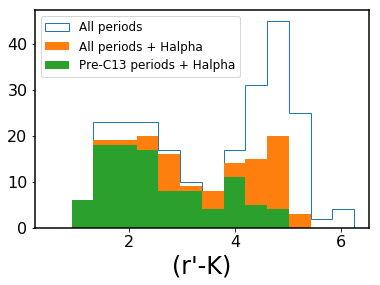

In [27]:
bins = np.linspace(0.5,6.25,15)
plt.hist(hdat["RPRIME_K"][pperiods_allk2>0],bins=bins,histtype="step",
        label="All periods")
plt.hist(hdat["RPRIME_K"][(new_specmatch>0) & (pperiods_allk2>0)],
         bins=bins,label="All periods + Halpha")
plt.hist(hdat["RPRIME_K"][(hdat["MDM_SPECMATCH"]>0) & (pperiods_allk2>0)],
         bins=bins,label="Pre-C13 periods + Halpha")
plt.xlabel("(r'-K)")
plt.legend(loc=2,fontsize=12)

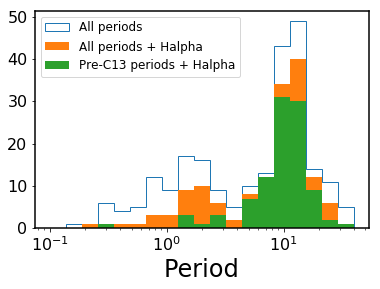

In [29]:
bins = np.logspace(-1,np.log10(40),20)
plt.hist(pperiods_allk2[pperiods_allk2>0],bins=bins,histtype="step",
        label="All periods")
plt.hist(pperiods_allk2[(new_specmatch>0) & (pperiods_allk2>0)],
         bins=bins,label="All periods + Halpha")
plt.hist(pperiods_allk2[(hdat["MDM_SPECMATCH"]>0) & (pperiods_allk2>0)],
         bins=bins,label="Pre-C13 periods + Halpha")
plt.xlabel("Period")
plt.legend(loc=2,fontsize=12)
plt.xscale("log")

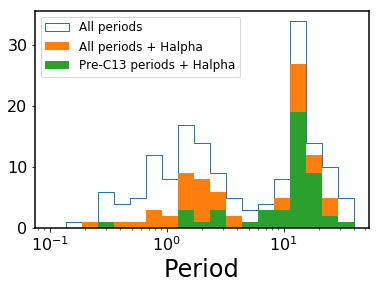

In [30]:
bins = np.logspace(-1,np.log10(40),20)
mass_lim = hdat["KH_MASS"]<0.8
plt.hist(pperiods_allk2[(pperiods_allk2>0) & mass_lim],bins=bins,histtype="step",
        label="All periods")
plt.hist(pperiods_allk2[(new_specmatch>0) & (pperiods_allk2>0) & mass_lim],
         bins=bins,label="All periods + Halpha")
plt.hist(pperiods_allk2[(hdat["MDM_SPECMATCH"]>0) & (pperiods_allk2>0) & mass_lim],
         bins=bins,label="Pre-C13 periods + Halpha")
plt.xlabel("Period")
plt.legend(loc=2,fontsize=12)
plt.xscale("log")